<a href="https://colab.research.google.com/github/sobhanshukueian/BYOL/blob/main/BYOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %matplotlib inline
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os
import shutil
import cv2
import glob
import matplotlib
# matplotlib.use("TKAgg")
import matplotlib.pyplot as plt

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 250

In [2]:
def reproducibility(SEED):
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
reproducibility(666)

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
root_path = "./data"
# Download Dataset
train =  datasets.CIFAR10(root=root_path, train=True, download=True)
test = datasets.CIFAR10(root=root_path, train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [29]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=32),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.9,
                                                                     contrast=0.9,
                                                                     saturation=0.9,
                                                                     hue=0.4)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])
val_transformation = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])

In [30]:
class DataLoaderCIFAR(Dataset):
    def __init__(self, transform, dataset):
        self.transform = transform
        self.dataset=dataset

        self.classes=['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck','unlabelled']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label=self.dataset[index]
        if self.transform is not None:
            img0 = self.transform(img)
            img1 = self.transform(img)
        

        return img0, img1, label

In [31]:
# Initialize the network
siamese_dataset = DataLoaderCIFAR(contrast_transforms, train)
siamese_testset = DataLoaderCIFAR(val_transformation, test)

In [32]:
len(siamese_dataset)

50000

In [33]:
50000/250

200.0

In [34]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset, shuffle=False, num_workers=2, batch_size=BATCH_SIZE)

# Load the testing dataset
test_dataloader = DataLoader(siamese_testset, shuffle=False, num_workers=2, batch_size=BATCH_SIZE)

In [35]:
train_features = next(iter(train_dataloader))
print(len(train_dataloader))
print("Train Images 1 Shape: {}\nTrain Images 2 Shape: {}\nTrain Data Labels Shape: {}".format(train_features[0].shape, train_features[1].shape, train_features[2].shape,))

test_features = next(iter(train_dataloader))
print(len(test_dataloader))
print("Test Images 1 Shape: {}\nTest Images 2 Shape: {}\nTest Data Labels Shape: {}".format(test_features[0].shape, test_features[1].shape, test_features[2].shape,))


200
Train Images 1 Shape: torch.Size([250, 3, 32, 32])
Train Images 2 Shape: torch.Size([250, 3, 32, 32])
Train Data Labels Shape: torch.Size([250])
40
Test Images 1 Shape: torch.Size([250, 3, 32, 32])
Test Images 2 Shape: torch.Size([250, 3, 32, 32])
Test Data Labels Shape: torch.Size([250])


In [36]:
# Showing images
def show_batch(data, cols = BATCH_SIZE, image_size=32):
    fig, ax = plt.subplots(2, cols, figsize=(cols*20, 2*20))
    for index in range(cols):
        ax[0, index].imshow(data[0][index].view(3, image_size,image_size).permute(1 , 2 , 0), interpolation='nearest')
        ax[1, index].imshow(data[1][index].view(3, image_size,image_size).permute(1 , 2 , 0), interpolation='nearest')
    plt.show()
    print(data[2].numpy().reshape(-1))

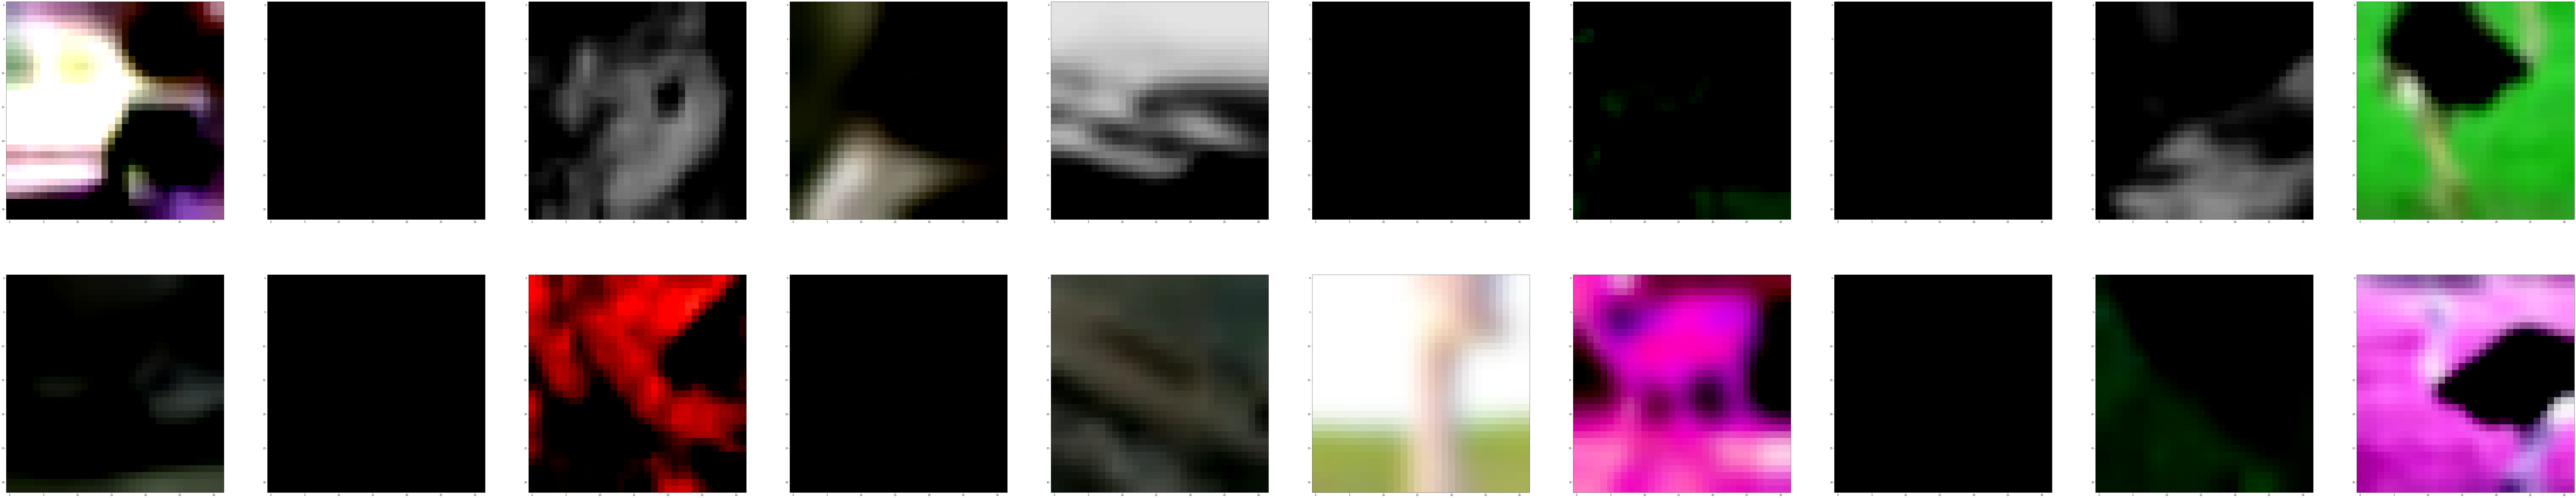

[1 6 6 2 8 2 4 9 2 2]


In [37]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=10)

# Extract one batch
example_batch = next(iter(vis_dataloader))
show_batch(example_batch, cols=10)

In [53]:
OUTPUT_EMBEDDING_SIZE = 32
OUTPUT_SIZE = 32
import copy

class EMA():
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.alpha + (1 - self.alpha) * new

#create the Siamese Neural Network
class BYOLNetwork(nn.Module):

    def __init__(self, in_features=512, hidden_size=4096, embedding_size=256, projection_size=256, projection_hidden_size=2048, batch_norm_mlp=True):
        super(BYOLNetwork, self).__init__()
        self.online = self.get_rep_and_proj(in_features, embedding_size, hidden_size, batch_norm_mlp)
        self.predictor = self.get_cnn_block(projection_size, projection_size, projection_hidden_size)
        self.target = copy.deepcopy(self.online)
        self.ema = EMA(0.99)

    def get_cnn_block(self, dim, embedding_size=256, hidden_size=2048, batch_norm_mlp=False):
        norm = nn.BatchNorm1d(hidden_size) #if batch_norm_mlp else nn.Identity()
        return nn.Sequential(
            nn.Linear(dim, hidden_size),
            norm,
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, embedding_size)
        )

    def get_rep_and_proj(self, in_features, embedding_size, hidden_size, batch_norm_mlp):
        self.backbone = torchvision.models.resnet18(num_classes=hidden_size)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.backbone.fc = nn.Sequential(
            self.backbone.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, in_features)
        )
        proj = self.get_cnn_block(in_features, embedding_size, hidden_size=hidden_size, batch_norm_mlp=batch_norm_mlp)
        return nn.Sequential(self.backbone, proj)

    @torch.no_grad()
    def update_moving_average(self):
        assert self.target is not None, 'target encoder has not been created yet'

        for online_params, target_params in zip(self.online.parameters(), self.target.parameters()):
            old_weight, up_weight = target_params.data, online_params.data
            target_params.data = self.ema.update_average(old_weight, up_weight)


    def forward(self, x1, x2=None, return_embedding=False):
        if return_embedding or (x2 is None):
            return self.online(x1)

        # online projections: backbone + MLP projection
        x1_1 = self.online(x1)
        x1_2 = self.online(x2)

        # additional online's MLP head called predictor
        x1_1_pred = self.predictor(x1_1)
        x1_2_pred = self.predictor(x1_2)

        with torch.no_grad():
            # teacher processes the images and makes projections: backbone + MLP
            x2_1 = self.target(x1).detach_()
            x2_2 = self.target(x2).detach_()

        return x1_1_pred, x1_2_pred, x2_1, x2_2

temp1 = torch.rand((6, 3, 32, 32))
temp2 = torch.rand((6, 3, 32, 32))
temp_model = BYOLNetwork()
res = temp_model(temp1, temp2)
res[0].size(), res[1].size(), res[2].size(), res[3].size()

(torch.Size([6, 256]),
 torch.Size([6, 256]),
 torch.Size([6, 256]),
 torch.Size([6, 256]))

In [54]:
def get_color(idx):
    return list(matplotlib.colors.cnames.keys())[idx]
  
def get_colors(idxs):
    res = []
    for idx in idxs:
      res.append(get_color(idx))
    return res 

In [55]:
def define_param_groups(model, weight_decay, optimizer_name):
    def exclude_from_wd_and_adaptation(name):
        if 'bn' in name:
            return True
        if optimizer_name == 'lars' and 'bias' in name:
            return True

    param_groups = [
        {
            'params': [p for name, p in model.named_parameters() if not exclude_from_wd_and_adaptation(name)],
            'weight_decay': weight_decay,
            'layer_adaptation': True,
        },
        {
            'params': [p for name, p in model.named_parameters() if exclude_from_wd_and_adaptation(name)],
            'weight_decay': 0.,
            'layer_adaptation': False,
        },
    ]
    return param_groups

In [56]:
from torch.optim.optimizer import Optimizer, required
import torch

# almost copy paste from https://github.com/noahgolmant/pytorch-lars/blob/master/lars.py
class LARS(Optimizer):
    r"""Implements LARS (Layer-wise Adaptive Rate Scaling).
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        eta (float, optional): LARS coefficient as used in the paper (default: 1e-3)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)
        epsilon (float, optional): epsilon to prevent zero division (default: 0)
    Example:
        >>> optimizer = torch.optim.LARS(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    """

    def __init__(self, params, lr=required, momentum=0, eta=1e-3, dampening=0,
                 weight_decay=0, nesterov=False, epsilon=0):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, eta=eta, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov, epsilon=epsilon)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(LARS, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(LARS, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            eta = group['eta']
            dampening = group['dampening']
            nesterov = group['nesterov']
            epsilon = group['epsilon']

            for p in group['params']:
                if p.grad is None:
                    continue
                w_norm = torch.norm(p.data)
                g_norm = torch.norm(p.grad.data)
                if w_norm * g_norm > 0:
                    local_lr = eta * w_norm / (g_norm +
                        weight_decay * w_norm + epsilon)
                else:
                    local_lr = 1
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(p.data, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                    buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(d_p, alpha=-local_lr * group['lr'])

        return loss

In [57]:

#@title Some Configurations
EPOCHS = 100 #@param {type:"integer"}
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' #@param
VERBOSE = 0 #@param [0, 1, 2, 3] {type:"raw"}
SAVE_PLOTS = True #@param {type:"boolean"}
VISUALIZE_PLOTS = True #@param {type:"boolean"}
SAVE_DIR = "/content/drive/MyDrive/byol/runs" #@param
MODEL_NAME = "BYOL Model" #@param
WEIGHTS = None


Start Training Process 
Time: Thu Mar 23 22:36:21 2023


Epoch: 0/100	Validation Loss Loss: 4.059233665466309  : 100%|██████████| 40/40 [00:04<00:00,  9.59it/s]


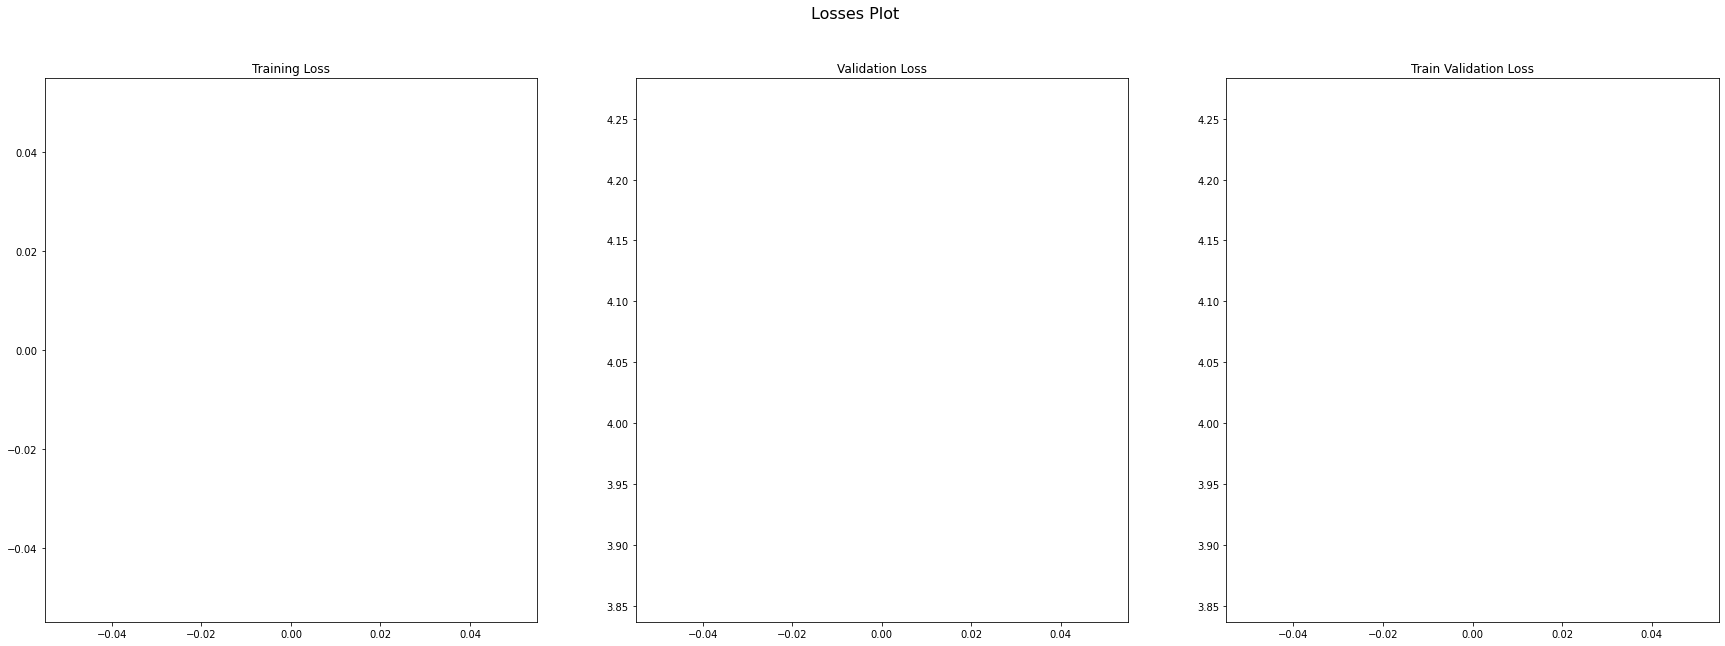

(8000, 256) (8000,)
KNN Accuracy: 0.272


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Kmeans Adjusted Rand Index: 0.020121308173025182


Epoch: 1/100	Train Loss: 0.6086706519126892  :  40%|████      | 80/200 [01:02<01:30,  1.32it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4225abe160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4225abe160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/d

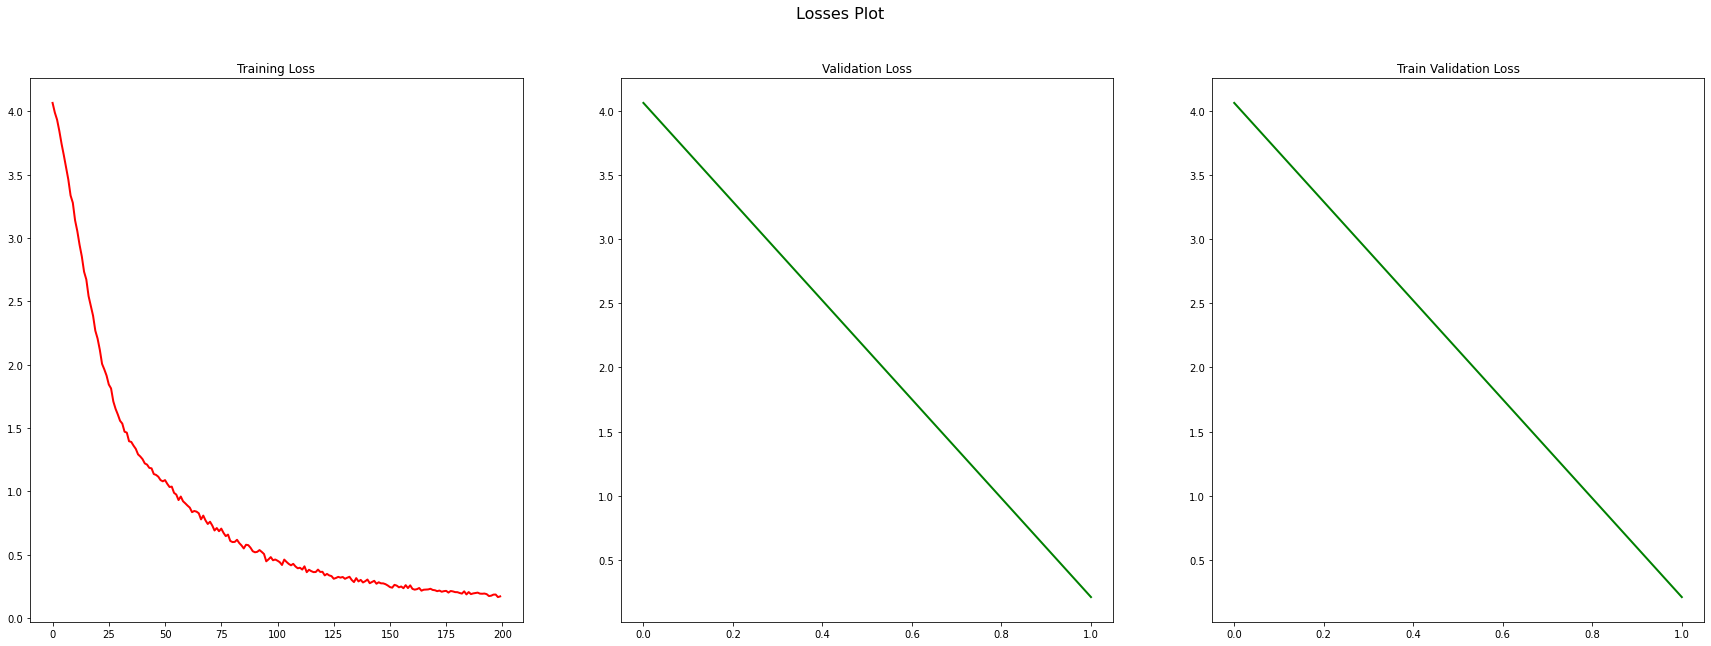

(8000, 256) (8000,)
KNN Accuracy: 0.2395


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Kmeans Adjusted Rand Index: 0.02717774078017082


Epoch: 2/100	Train Loss: 0.1366373747587204  :  19%|█▉        | 38/200 [00:30<01:43,  1.56it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4225abe160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4225abe160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/d

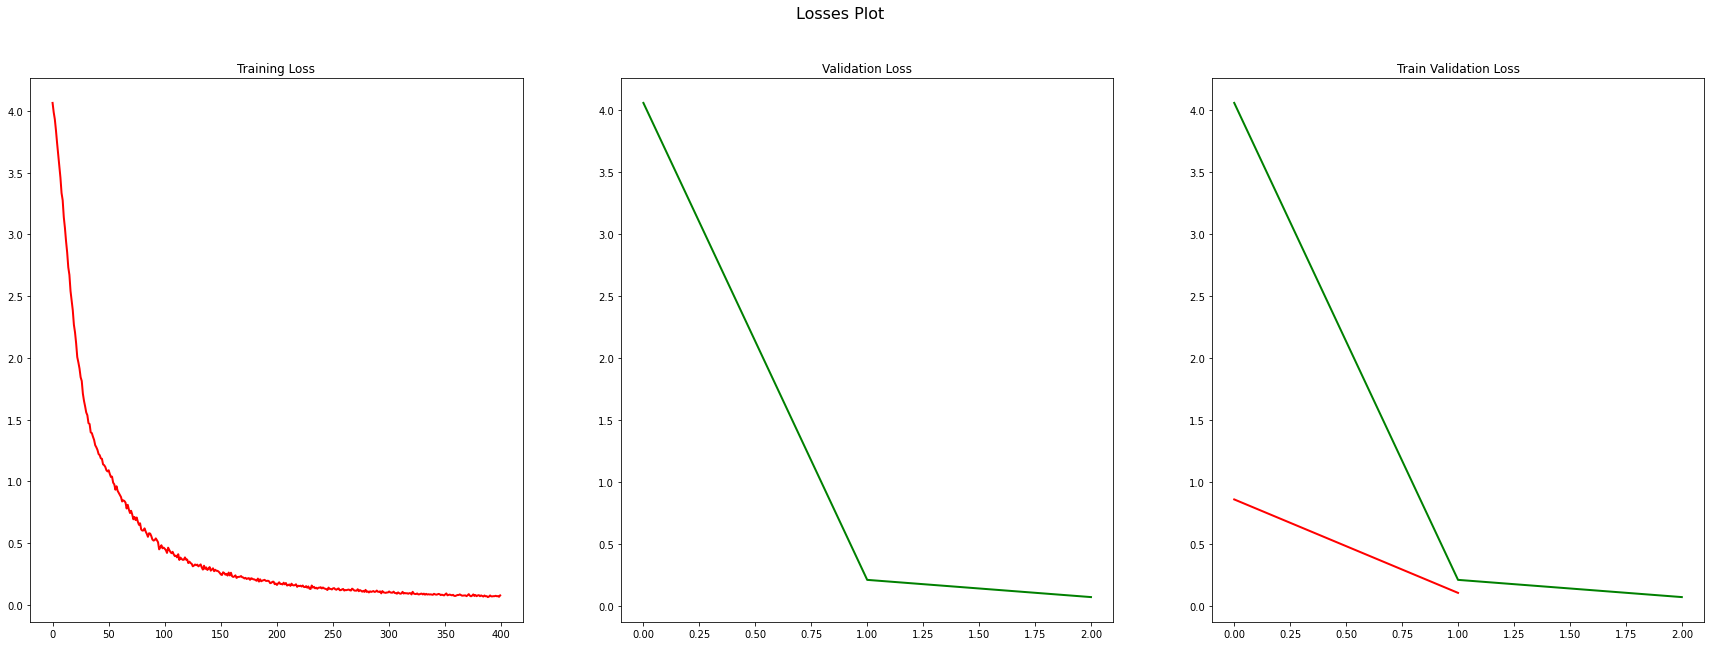

(8000, 256) (8000,)
KNN Accuracy: 0.2505


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Kmeans Adjusted Rand Index: 0.027141490983867672


Epoch: 3/100	Train Loss: 0.05705704540014267  : 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
Epoch: 3/100	Validation Loss Loss: 0.06526869535446167  : 100%|██████████| 40/40 [00:05<00:00,  7.62it/s]


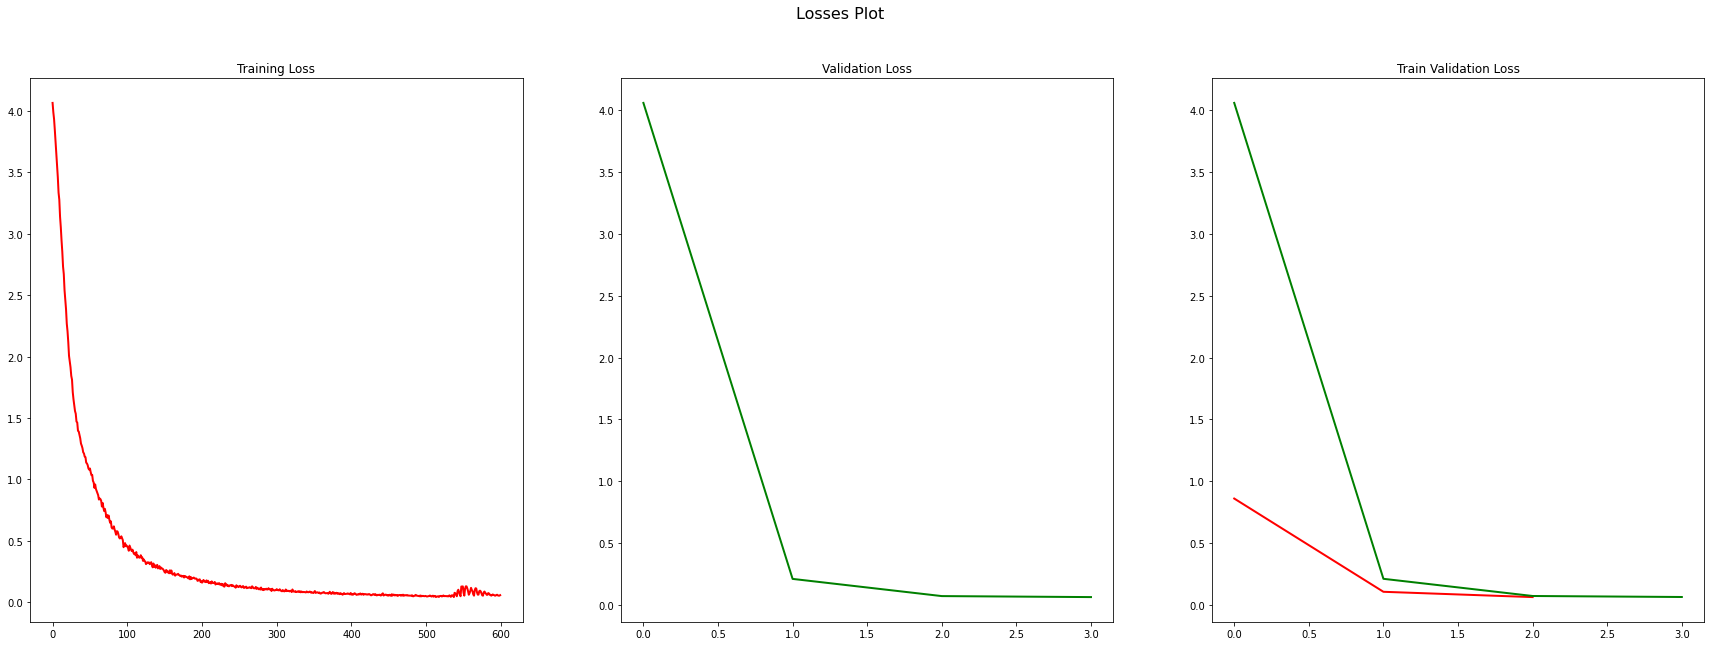

(8000, 256) (8000,)
KNN Accuracy: 0.225


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Kmeans Adjusted Rand Index: 0.02958743711940294


Epoch: 4/100	Train Loss: 0.034637581557035446  : 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
Epoch: 4/100	Validation Loss Loss: 0.027572717517614365  : 100%|██████████| 40/40 [00:05<00:00,  7.88it/s]


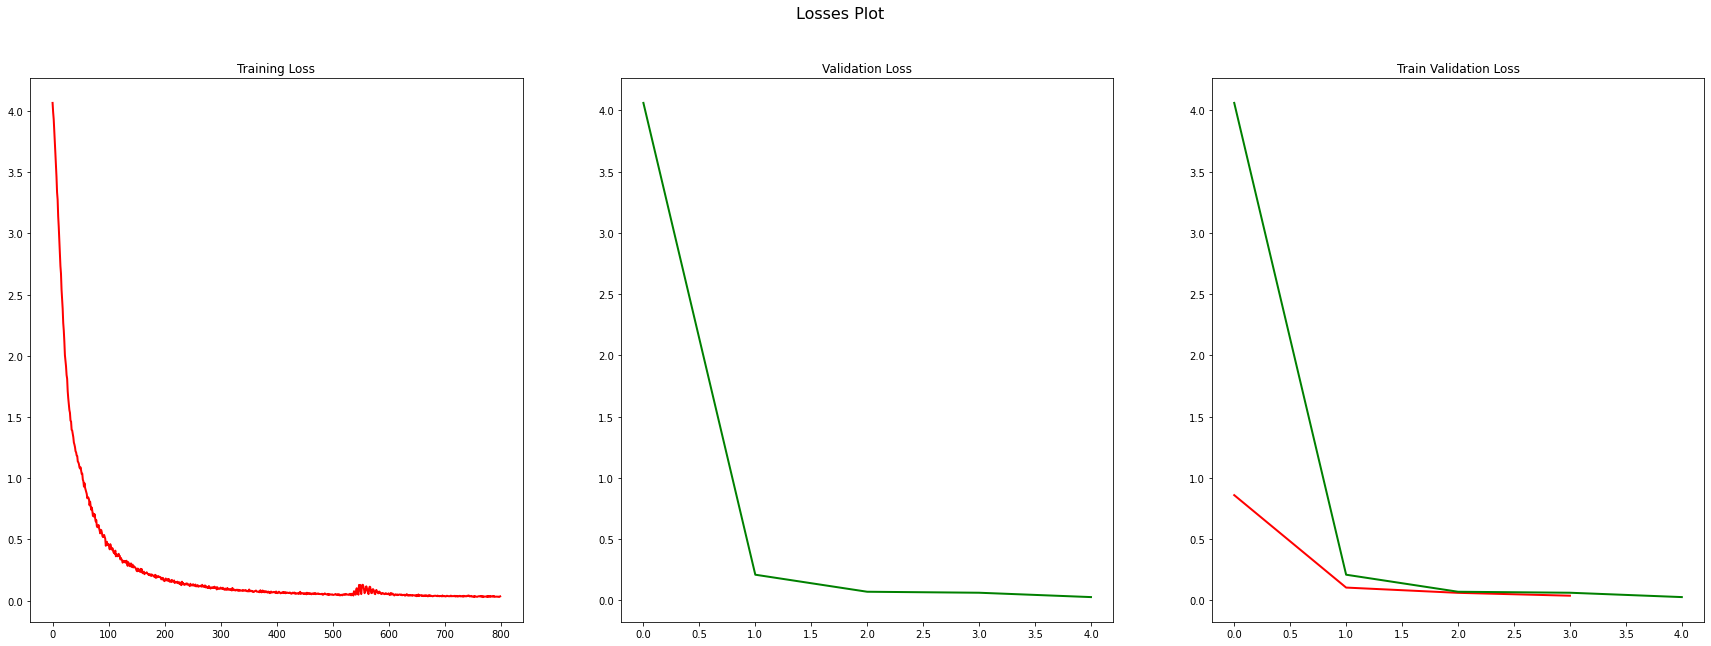

(8000, 256) (8000,)
KNN Accuracy: 0.2435


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Kmeans Adjusted Rand Index: 0.02704147674904813


Epoch: 5/100	Train Loss: 0.02363218553364277  : 100%|██████████| 200/200 [02:39<00:00,  1.25it/s]
Epoch: 5/100	Validation Loss Loss: 0.019009647890925407  : 100%|██████████| 40/40 [00:04<00:00,  9.26it/s]


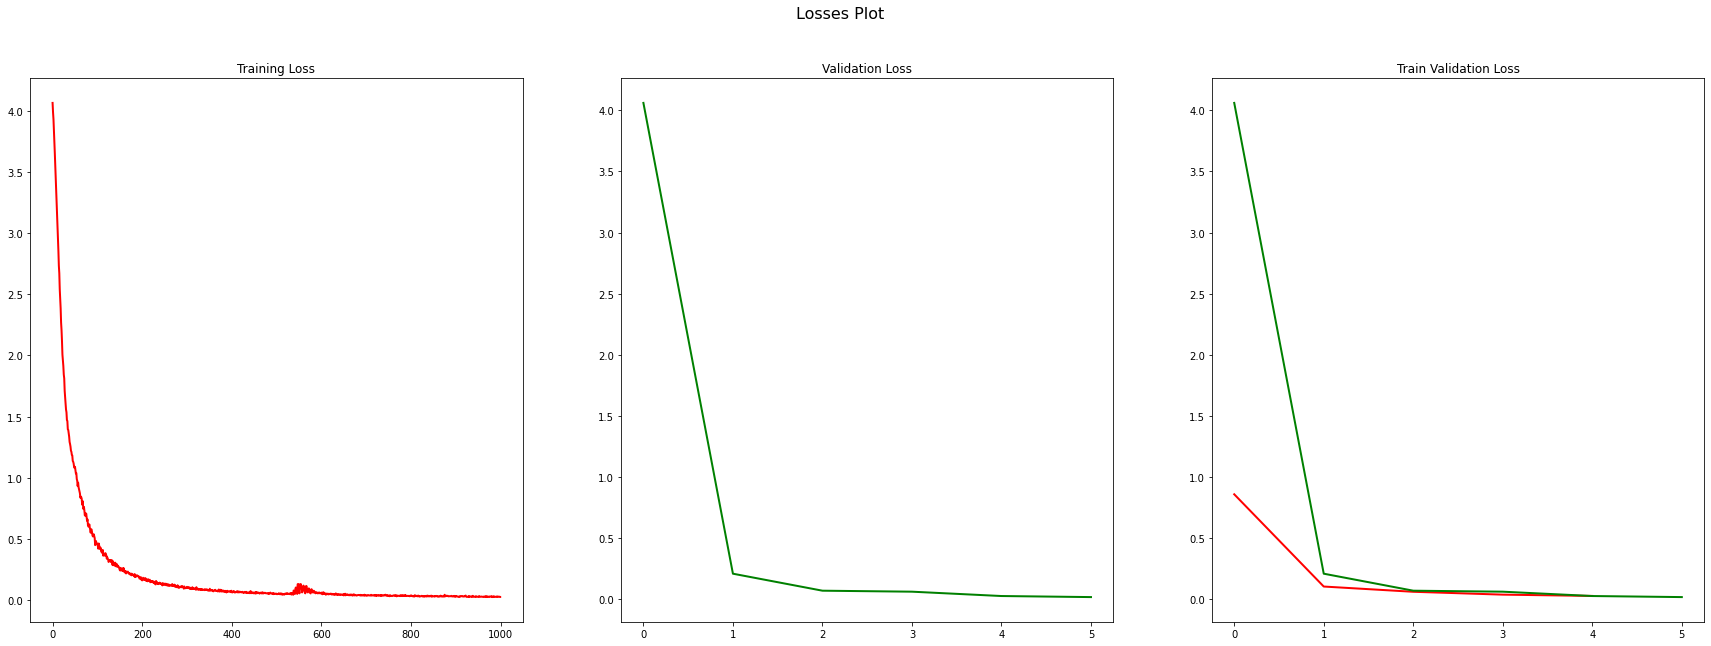

(8000, 256) (8000,)
KNN Accuracy: 0.246


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Kmeans Adjusted Rand Index: 0.025609188923001246


Epoch: 6/100	Train Loss: 0.023544298484921455  : 100%|██████████| 200/200 [02:40<00:00,  1.25it/s]
Epoch: 6/100	Validation Loss Loss: 0.015657363459467888  : 100%|██████████| 40/40 [00:04<00:00,  9.03it/s]


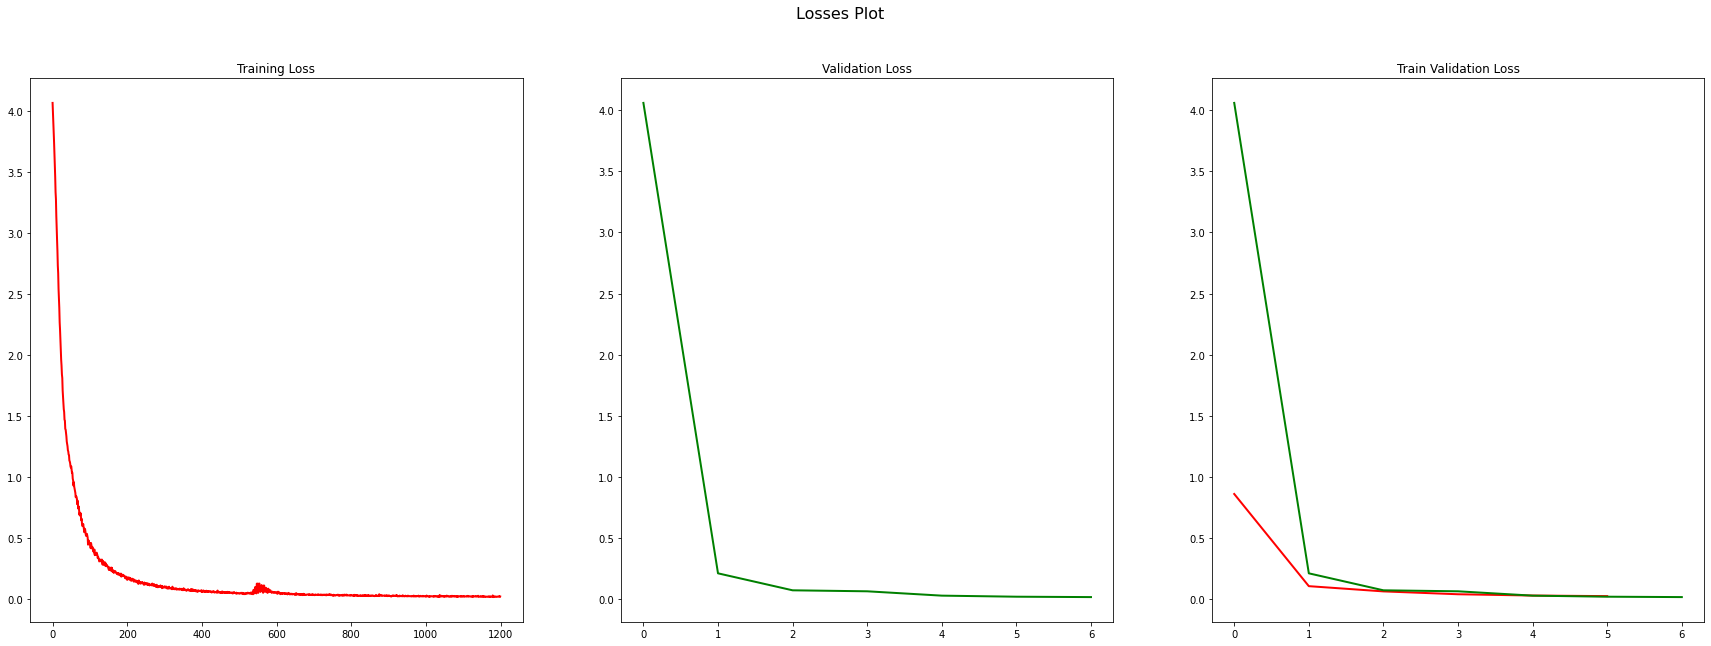

(8000, 256) (8000,)
KNN Accuracy: 0.245


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Kmeans Adjusted Rand Index: 0.023423138104254178


Epoch: 7/100	Train Loss: 0.018499337136745453  : 100%|██████████| 200/200 [02:40<00:00,  1.25it/s]
Epoch: 7/100	Validation Loss Loss: 0.014345929026603699  : 100%|██████████| 40/40 [00:05<00:00,  7.52it/s]


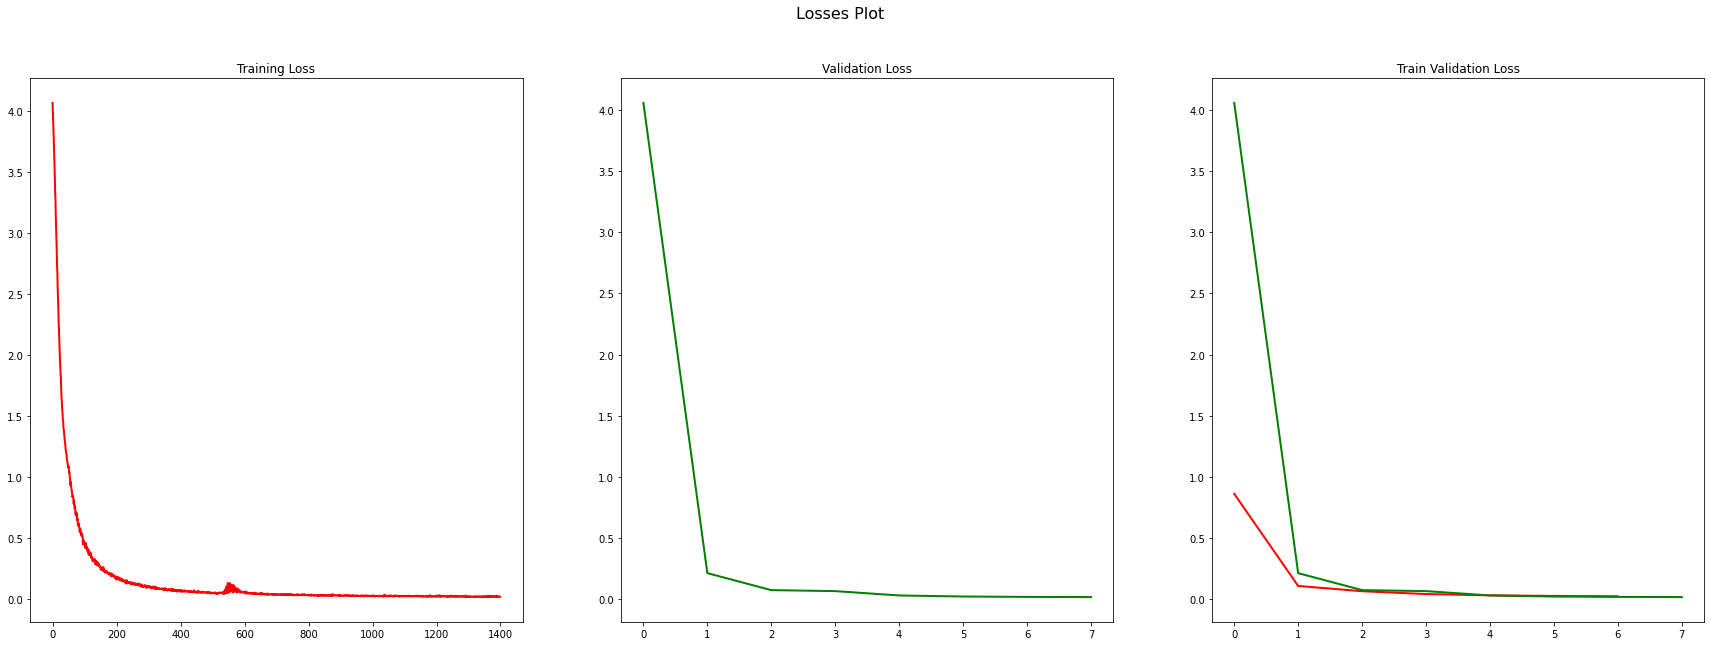

(8000, 256) (8000,)
KNN Accuracy: 0.2435


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Kmeans Adjusted Rand Index: 0.026721702452685375


Epoch: 8/100	Train Loss: 0.017768647521734238  : 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
Epoch: 8/100	Validation Loss Loss: 0.013267457485198975  : 100%|██████████| 40/40 [00:05<00:00,  7.04it/s]


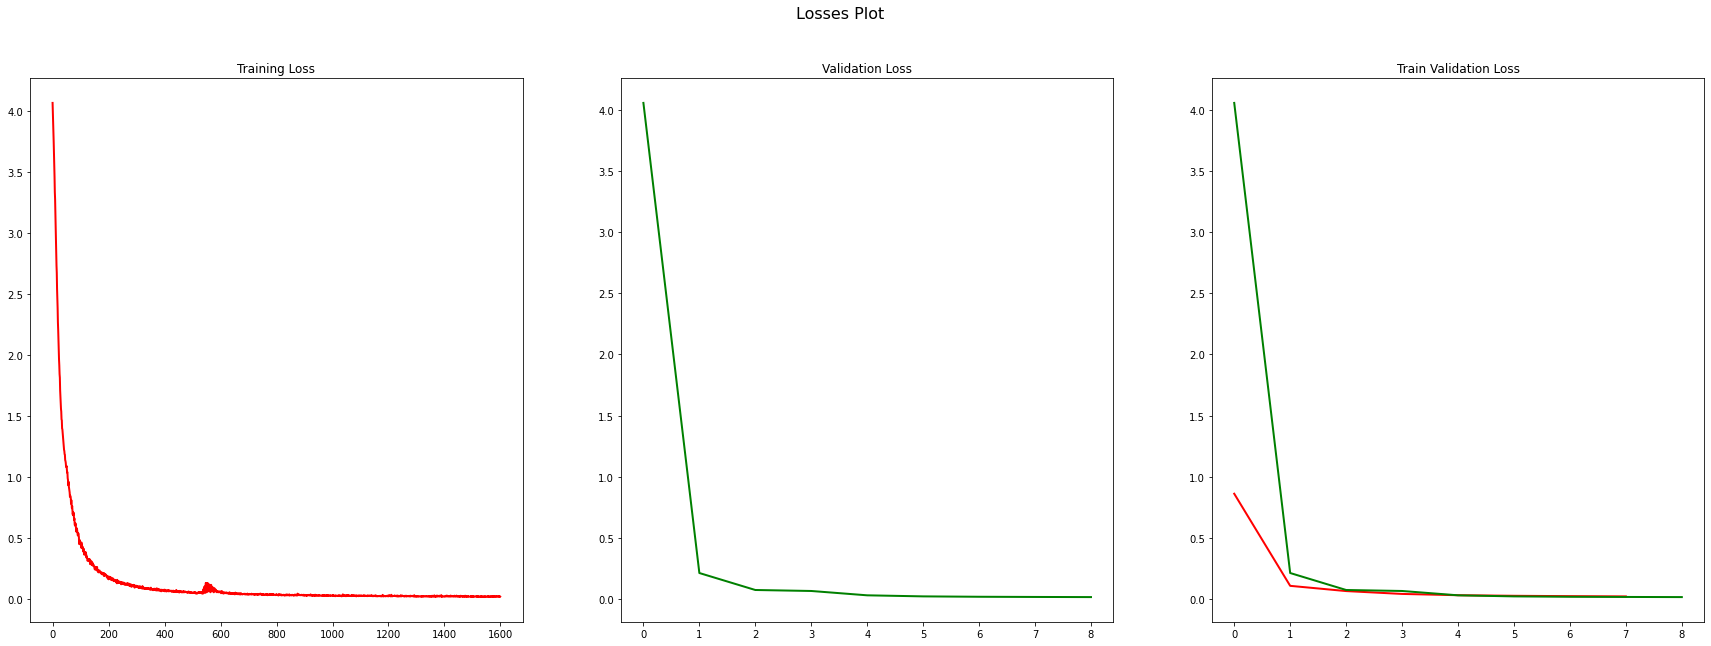

(8000, 256) (8000,)
KNN Accuracy: 0.2355


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Kmeans Adjusted Rand Index: 0.03029097976274968


Epoch: 9/100	Train Loss: 0.018426993861794472  : 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
Epoch: 9/100	Validation Loss Loss: 0.012495183385908604  : 100%|██████████| 40/40 [00:04<00:00,  8.99it/s]


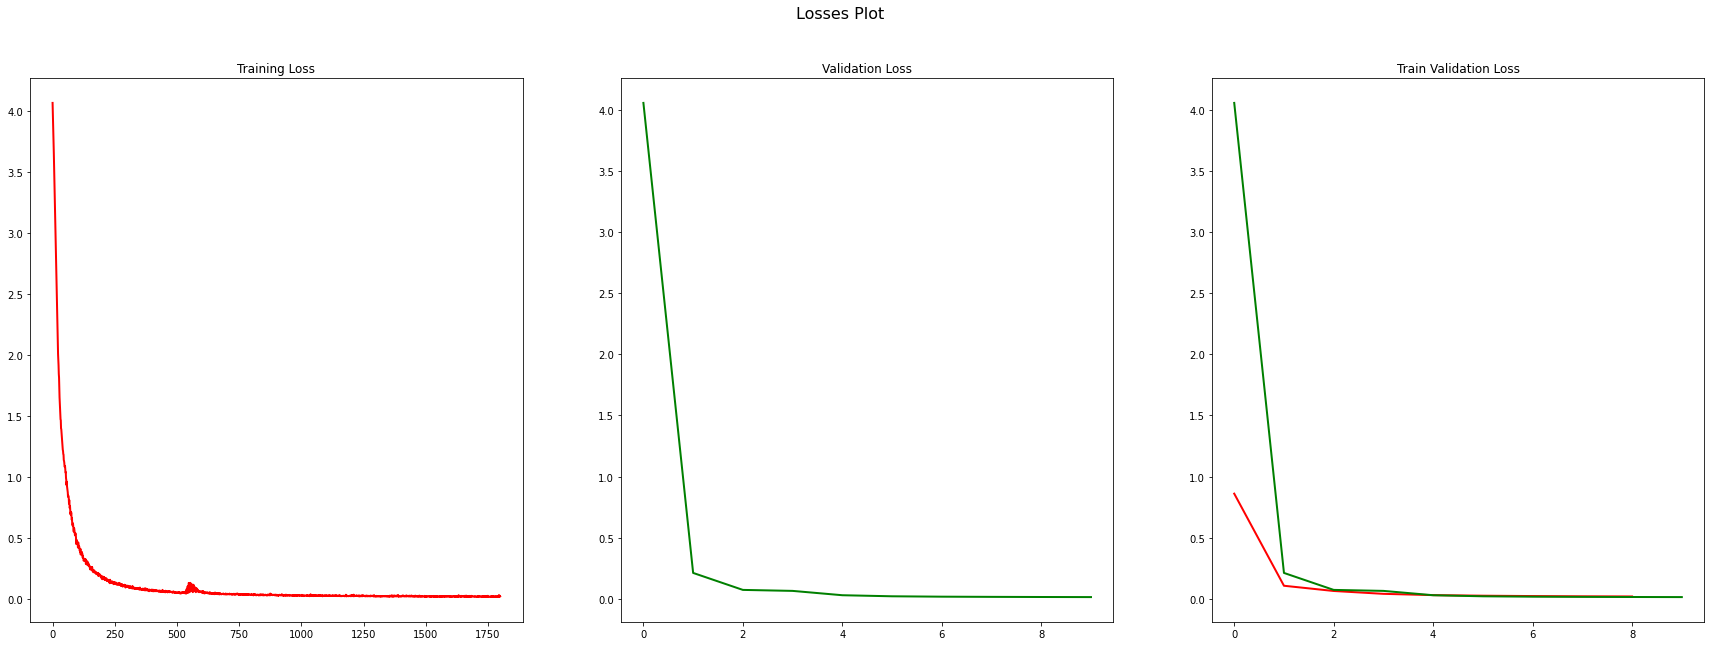

(8000, 256) (8000,)
KNN Accuracy: 0.2425


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Kmeans Adjusted Rand Index: 0.03003570512867547


Epoch: 10/100	Train Loss: 0.012902721762657166  : 100%|██████████| 200/200 [02:39<00:00,  1.25it/s]
Epoch: 10/100	Validation Loss Loss: 0.010636745020747185  : 100%|██████████| 40/40 [00:04<00:00,  9.02it/s]


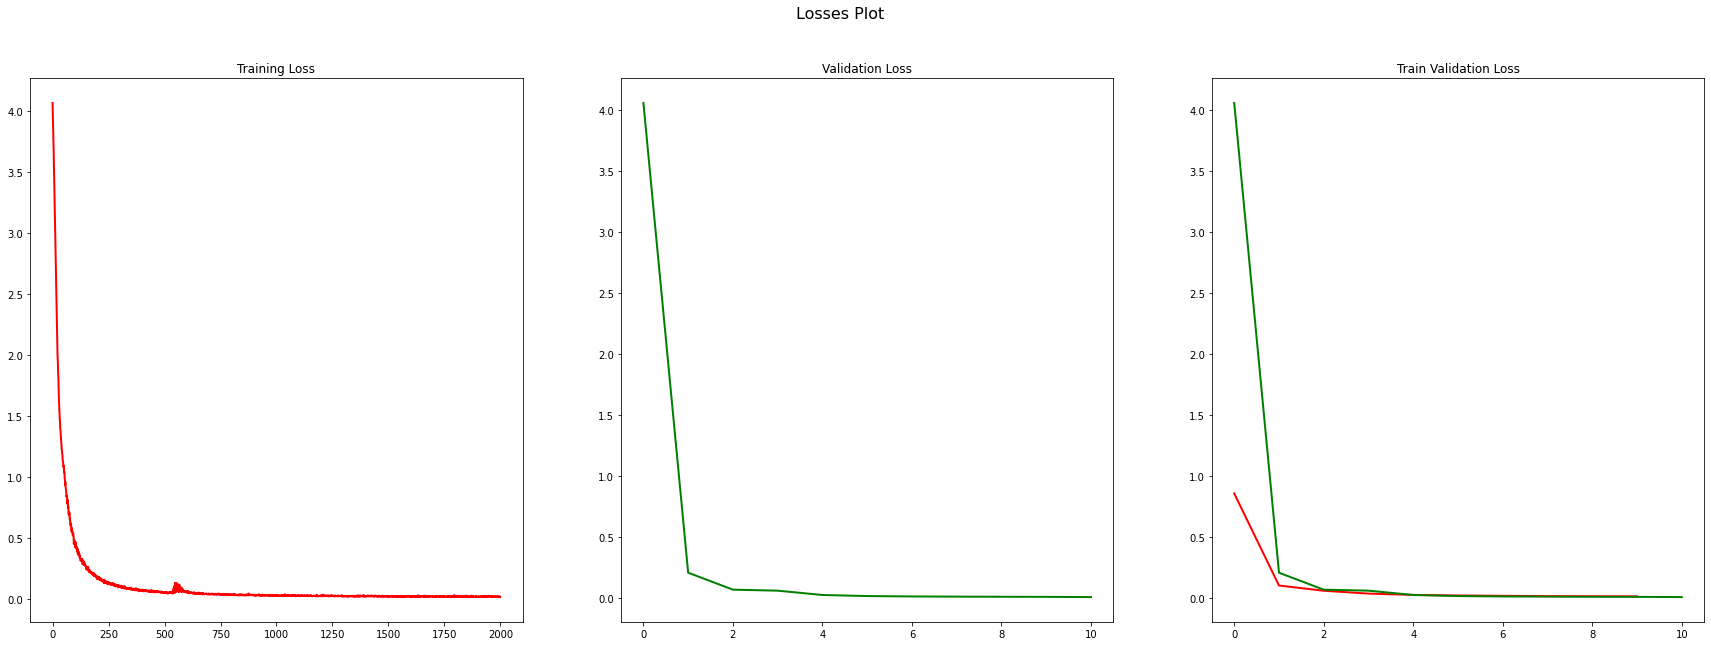

(8000, 256) (8000,)
KNN Accuracy: 0.24


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Kmeans Adjusted Rand Index: 0.02955148023344408


Epoch: 11/100	Train Loss: 0.02777205780148506  : 100%|██████████| 200/200 [02:36<00:00,  1.28it/s]
Epoch: 11/100	Validation Loss Loss: 0.01461262907832861  : 100%|██████████| 40/40 [00:04<00:00,  8.95it/s]


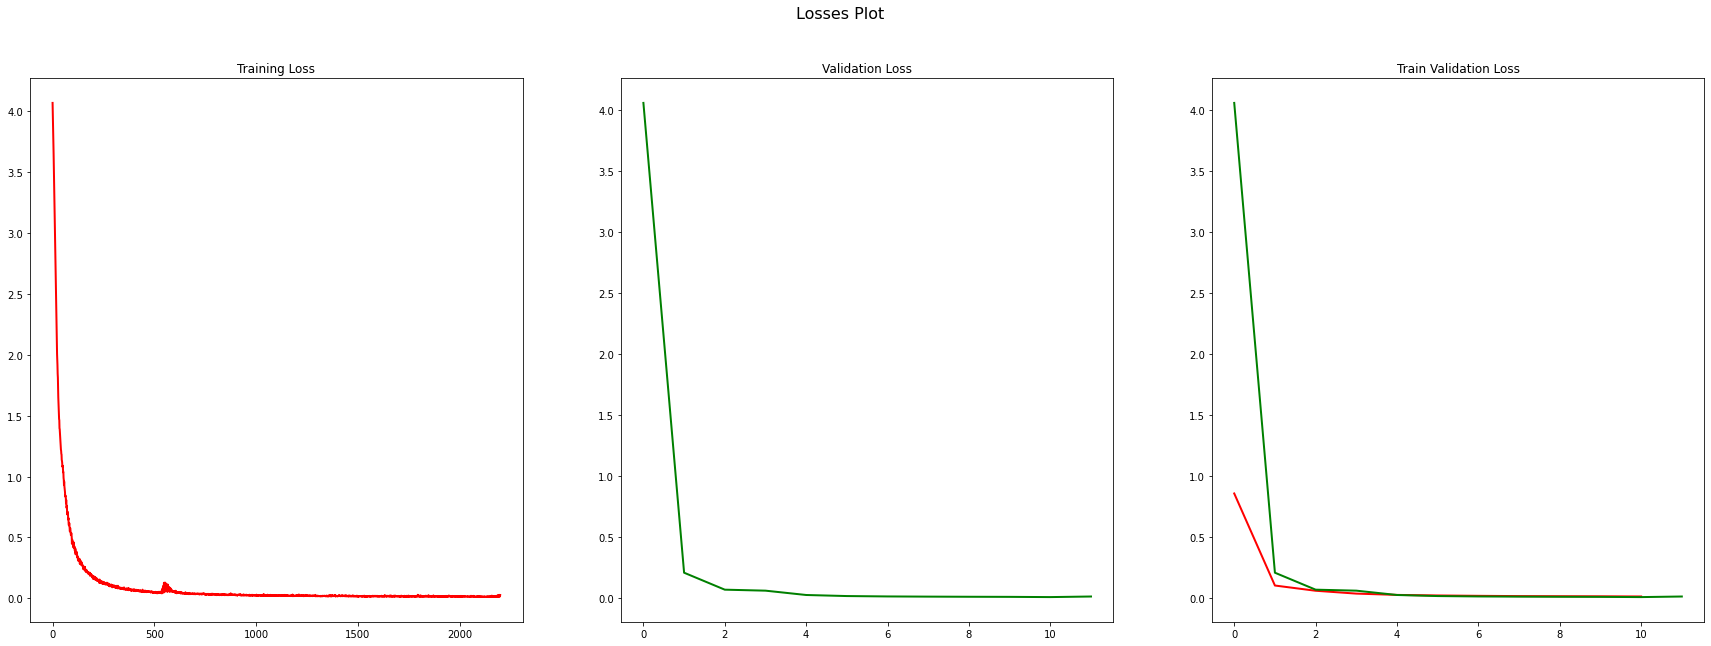

(8000, 256) (8000,)
KNN Accuracy: 0.2405


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Kmeans Adjusted Rand Index: 0.03245924272764555


Epoch: 12/100	Train Loss: 0.014871123246848583  : 100%|██████████| 200/200 [02:38<00:00,  1.27it/s]
Epoch: 12/100	Validation Loss Loss: 0.009869847446680069  : 100%|██████████| 40/40 [00:04<00:00,  9.01it/s]


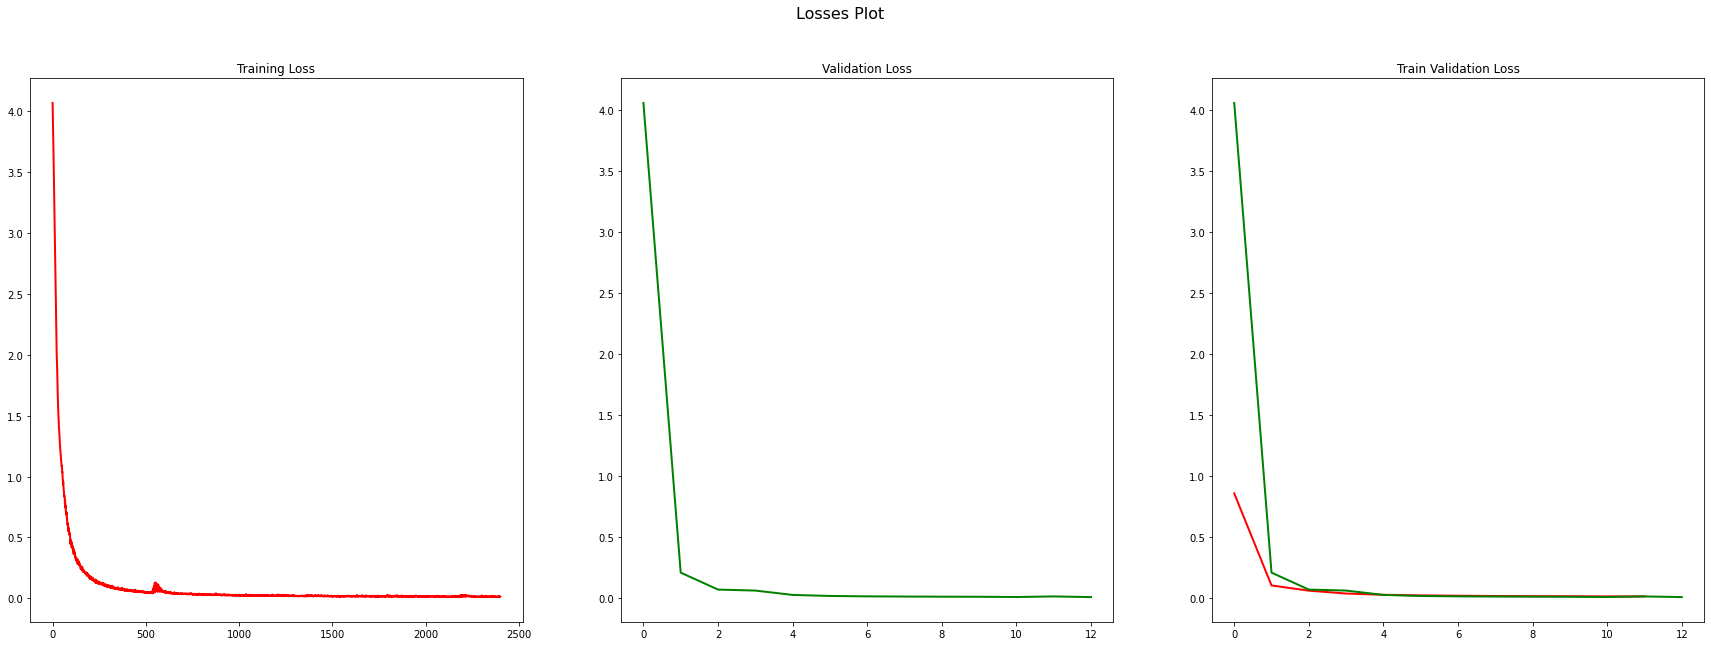

(8000, 256) (8000,)
KNN Accuracy: 0.2475


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Kmeans Adjusted Rand Index: 0.03062019162302423


Epoch: 13/100	Train Loss: 0.010062632150948048  : 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
Epoch: 13/100	Validation Loss Loss: 0.011221728287637234  : 100%|██████████| 40/40 [00:05<00:00,  7.98it/s]


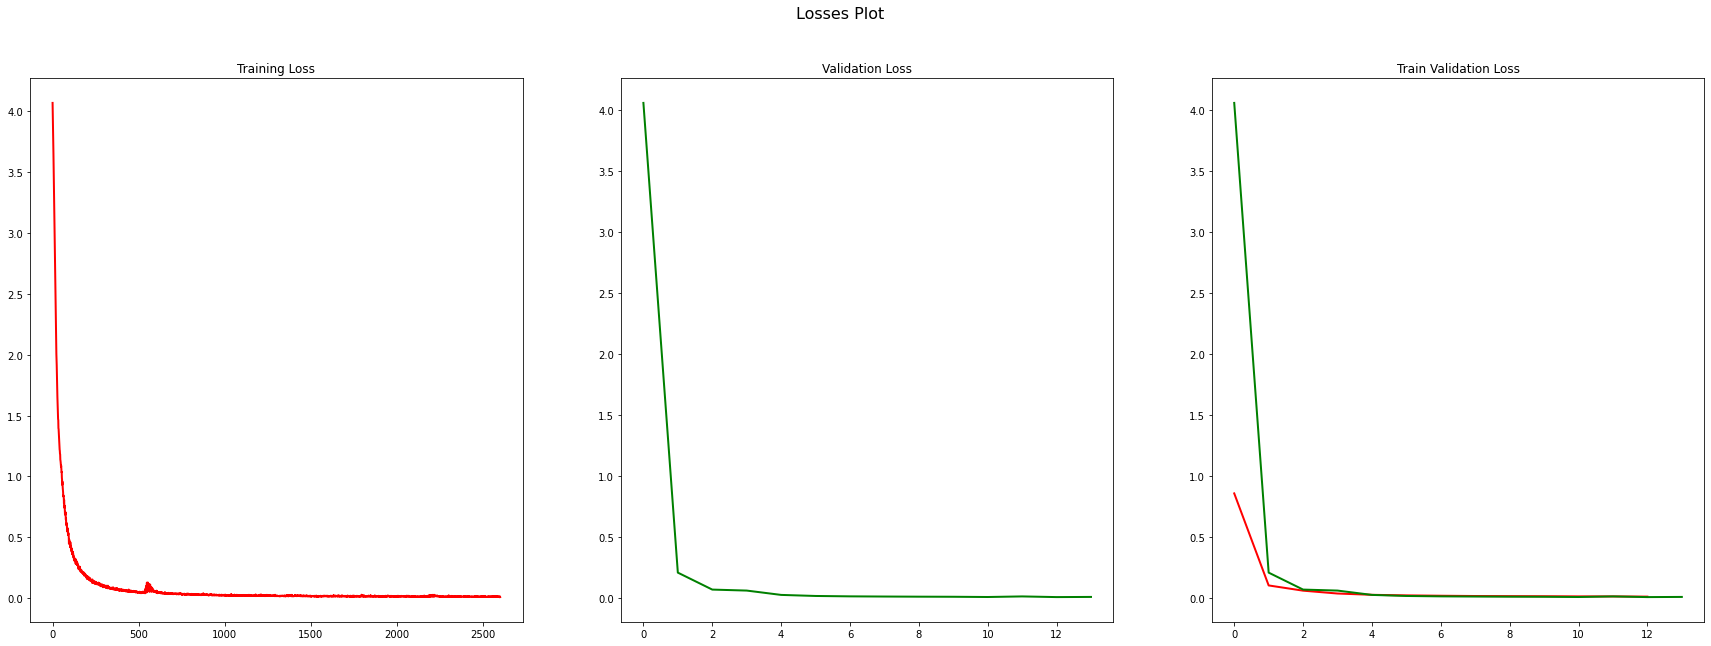

(8000, 256) (8000,)
KNN Accuracy: 0.2565


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Kmeans Adjusted Rand Index: 0.032049812740018474


Epoch: 14/100	Train Loss: 0.013957426883280277  : 100%|██████████| 200/200 [02:43<00:00,  1.22it/s]
Epoch: 14/100	Validation Loss Loss: 0.009603794664144516  : 100%|██████████| 40/40 [00:04<00:00,  8.22it/s]


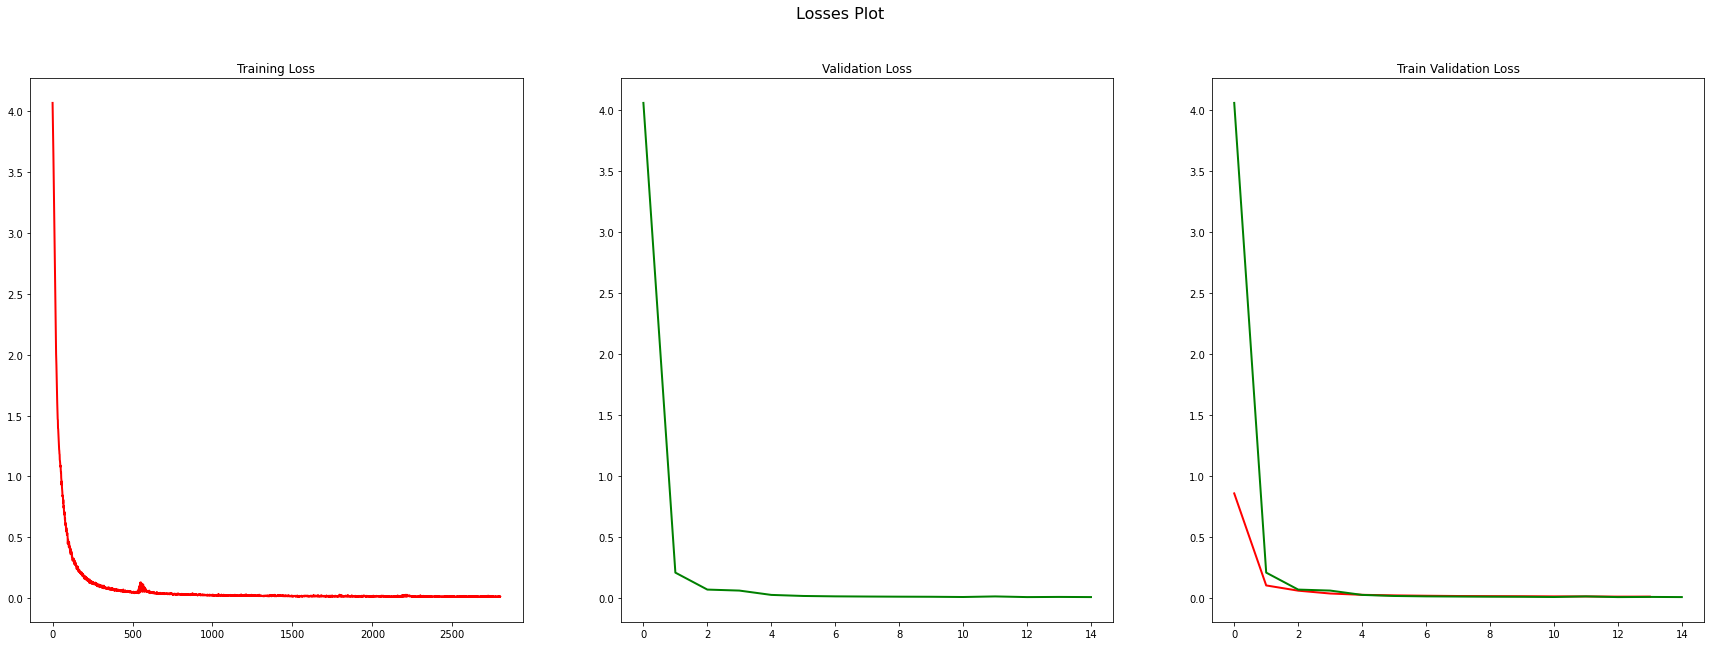

(8000, 256) (8000,)
KNN Accuracy: 0.246


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Kmeans Adjusted Rand Index: 0.029898077778328445


Epoch: 15/100	Train Loss: 0.011334965005517006  :   2%|▏         | 4/200 [00:04<02:10,  1.50it/s]

In [ ]:
import os
import time
import math
from copy import deepcopy
import os.path as osp
import shutil
from prettytable import PrettyTable
import json
from sklearn.metrics import auc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from tqdm import tqdm

import numpy as np
import torch
from torch.cuda import amp
# from torch.utils.tensorboard import SummaryWriter

class Trainer:
    # -----------------------------------------------INITIALIZE TRAINING-------------------------------------------------------------
    def __init__(self, device=device, epochs=EPOCHS, batch_size=BATCH_SIZE, save_dir=SAVE_DIR, train_loader=train_dataloader, valid_loader=test_dataloader, weights=WEIGHTS, verbose=VERBOSE, visualize_plots=VISUALIZE_PLOTS, save_plots=SAVE_PLOTS, model_name=MODEL_NAME):
        self.device = device
        self.save_dir = save_dir
        self.batch_size = batch_size
        self.epochs = epochs
        self.use_ema = False
        self.model_name = model_name
        self.weights = weights
        self.visualize_plots = visualize_plots
        self.save_plots = save_plots
        # 0 == nothing || 1 == model architecture || 2 == print optimizer || 3 == model parameters
        self.verbose = verbose
        self.train_losses=[]
        self.val_losses=[]
        self.conf = {'Name' : self.model_name, 'Bacth_size' : self.batch_size, 'Max_iter_num' : '', 'Epochs' : self.epochs, 'Trained_epoch' : 0, 'Optimizer' : '', "Model" : '', 'Parameter_size' : ''}

        temm=0
        tmp_save_dir = self.save_dir
        while osp.exists(tmp_save_dir):
            tmp_save_dir = self.save_dir
            temm+=1
            tmp_save_dir += (str(temm))
        self.save_dir = tmp_save_dir
        del temm


        # get data loader
        self.train_loader, self.valid_loader = train_loader, valid_loader
        self.max_stepnum = len(self.train_loader)
        self.conf["Max_iter_num"] = self.max_stepnum
        
        # get model 
        self.model = self.get_model()
        if self.verbose > 2:
            self.count_parameters()

        # Get optimizer
        self.optimizer = self.get_optimizer()
    
        # tensorboard
        # self.tblogger = SummaryWriter(self.save_dir) 

# ----------------------------------------------------INITIALIZERS-------------------------------------------------------------------------
    # Get Model 
    def get_model(self):
        # Get Model Archutecture From Model Class.
        model = BYOLNetwork().to(self.device)

        # finetune if pretrained model is set
        if self.weights:  
            print(f'Loading state_dict from {self.weights} for fine-tuning...')
            model.load_state_dict(torch.load(self.weights))
        # Log Model
        if self.verbose > 0:
            print('Model: {}'.format(model))
        self.conf["Model"] = str(model)
        return model

    def get_optimizer(self, optimizer="LARS", lr0=0.001, momentum=0.937):
        assert optimizer == 'SGD' or 'Adam' or 'LARS', 'ERROR: unknown optimizer, use SGD defaulted'
        if optimizer == 'SGD':
            optim = torch.optim.SGD(self.model.parameters(), lr=lr0, momentum=momentum, nesterov=True)
        elif optimizer == 'Adam':
            optim = torch.optim.Adam(self.model.parameters(), lr=lr0, weight_decay=1e-6)
        elif optimizer == "LARS": 
            param_groups = define_param_groups(self.model, 1e-6, 'lars')    
            optim = LARS(param_groups, lr=0.1, momentum=0.9)


        if self.verbose > 1:
            print(f"{'optimizer:'} {type(optim).__name__}")
        self.conf['Optimizer'] = f"{'optimizer:'} {type(optim).__name__}"
        return optim

    # Loss Function Definition
    def compute_loss(self, x, y):
        # L2 normalization
        x = F.normalize(x, dim=-1, p=2)
        y = F.normalize(y, dim=-1, p=2)
        loss = 2 - 2 * (x * y).sum(dim=-1)
        return loss
    
    def count_parameters(self):
        table = PrettyTable(["Modules", "Parameters"])
        total_params = 0
        for name, parameter in self.model.named_parameters():
            if not parameter.requires_grad: continue
            params = parameter.numel()
            table.add_row([name, params])
            total_params+=params
        print(table)
        print(f"Total Trainable Params: {total_params}")
        self.conf["Parameter_size"] = total_params
# -------------------------------------------------------------------------------TRAINING PROCESS-----------------------------------------------
    @staticmethod
    def prepro_data(batch_data, device):
        images1 = batch_data[0].to(device)
        images2 = batch_data[1].to(device) 
        targets = batch_data[2].to(device)
        # targets = targets.repeat_interleave(4)
        # images = torch.cat([images1, images2], dim=0)
        # targets = torch.cat([targets, targets], dim=0)

        return images1, images2, targets

    # Each Train Step
    def train_step(self, batch_data):
        image1, image2, targets = self.prepro_data(batch_data, self.device)
        # forward
        # print(images.shape)
        with amp.autocast(enabled=self.device != 'cpu'):
            preds = self.model(image1, image2)
            loss = (self.compute_loss(preds[0], preds[2]) + self.compute_loss(preds[1], preds[3])).mean()


            # print("\n#############################################\n")
            # print(images)
            # print("\n#######################################\n")


            # COLS = len(images)
            # ROWS = 1
            # fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*10, ROWS*10))
            # # fig.suptitle("Embeddings Plot", fontsize=16)
            # for indx, img in enumerate(images):
            #     ax[indx].imshow(img.view(3, 100, 100).permute(1 , 2 , 0), interpolation='nearest')
            # plt.show()

            # print("\n=====================================================\n")
            # print(preds)
            # print("\n=====================================================\n")
        # backward
        # print("\n**********************************************\n")
        # print(loss)
        # print("\n**********************************************\n")

        # print("\n1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111\n")
        # for name, param in self.model.named_parameters():
        #     if torch.isnan(param).any():
        #         print("NaN values found in parameter:", name)
        # print("\n1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111\n")

        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()

        # Update Target 
        self.model.update_moving_average()
        # print("\n2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222\n")
        # for name, param in self.model.named_parameters():
        #     if torch.isnan(param).any():
        #         print("NaN values found in parameter:", name)
        # print("\n2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222\n")

        return loss.cpu().detach().numpy()#, [pred.cpu().detach().numpy() for pred in preds]#, targets.cpu().detach().numpy()


    # Each Validation Step
    def val_step(self, batch_data):
        self.model.eval()
        image1, image2, targets = self.prepro_data(batch_data, self.device)

        # forward
        preds = self.model(image1, image2)
        val_pred = self.model(image1)
        loss = (self.compute_loss(preds[0], preds[2]) + self.compute_loss(preds[1], preds[3])).mean()
        return loss.cpu().detach().numpy(), [pred.cpu().detach().numpy() for pred in preds], targets.cpu().detach().numpy(), val_pred.cpu().detach().numpy()

    # Training Process
    def train(self):
        try:
            # training process prerequisite
            self.start_time = time.time()
            print('Start Training Process \nTime: {}'.format(time.ctime(self.start_time)))
            self.scaler = amp.GradScaler(enabled=self.device != 'cpu')
            self.best_loss = np.inf

            # Epoch Loop
            for self.epoch in range(0, self.epochs):
                try:
                    self.conf["Trained_epoch"] = self.epoch

                    # labels = []
                    # embeddings = []
                    if self.epoch != 0:
                        # Training loop
                        self.model.train(True)
                        pbar = enumerate(self.train_loader)
                        pbar = tqdm(pbar, total=self.max_stepnum)
                        for step, batch_data in pbar:
                            self.train_loss = self.train_step(batch_data)
                            self.train_losses.append(self.train_loss)
                            pbar.set_description(f"Epoch: {self.epoch}/{self.epochs}\tTrain Loss: {self.train_loss}  ")
                            # embeddings.extend(embeds)
                            # labels.extend(targets)
                            # if step%5 == 0:
                            #     print(np.array(embeddings).shape)
                            #     X_train = np.array(embeddings).reshape(-1, np.array(embeddings).shape[-1])
                            #     y_train = np.array(labels).reshape(np.array(labels).shape[-1])
                            #     print(X_train.shape, y_train.shape)
                            #     # print(X_train, y_train)
                            #     break


                            
                        del pbar

                    val_labels = []
                    val_embeddings = []

                    # Validation Loop
                    vbar = enumerate(self.valid_loader)
                    vbar = tqdm(vbar, total=len(self.valid_loader))
                    for step, batch_data in vbar:
                        self.val_loss, val_embedss, val_targets, val_embeds = self.val_step(batch_data)
                        self.val_losses.append(self.val_loss)
                        vbar.set_description(f"Epoch: {self.epoch}/{self.epochs}\tValidation Loss Loss: {self.val_loss}  ")
                        val_embeddings.extend(val_embeds)
                        # print(val_embeddings[0].shape)

                        val_labels.extend(val_targets)
                    del vbar

                    # PLot Losses
                    self.plot_loss()
                    # PLot Embeddings
                    # plot_size = BATCH_SIZE
                    # self.plot_embeddings(np.array(val_embeddings), np.array(val_labels), 0)
                    # if self.epoch % 4 == 0 :
                    # print(np.array(val_embeddings).shape, np.array(val_labels).shape)

                    self.val_knn_kmeans(val_embeddings, val_labels)

                    # # Delete Data after PLotting
                    del val_embeddings, val_labels
                    
                    if self.val_loss < self.best_loss:
                        self.best_loss=self.val_loss
            
                except Exception as _:
                    print('ERROR in training steps.')
                    raise
                try:
                    self.save()
                except Exception as _:
                    print('ERROR in evaluate and save model.')
                    raise
        except Exception as _:
            print('ERROR in training loop or eval/save model.')
            raise
        finally:
            finish_time = time.time()
            print(f'\nTraining completed in {time.ctime(finish_time)} \nIts Done in: {(time.time() - self.start_time) / 3600:.3f} hours.') 


    def val_knn_kmeans(self, embeddings, labels):
        X_train = np.array(embeddings[:8000])
        y_train = np.array(labels[:8000])
        X_test = np.array(embeddings[8000:])
        y_test = np.array(labels[8000:])


        k = 10 
        knn = KNeighborsClassifier(n_neighbors=k)
        print(X_train.shape, y_train.shape)
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f'KNN Accuracy: {acc}')

        n_clusters = 10 
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(X_train)
        y_pred = kmeans.predict(X_test)
        ari = adjusted_rand_score(y_test, y_pred)
        print(f'Kmeans Adjusted Rand Index: {ari}')

    # -------------------------------------------------------Training Callback after each epoch--------------------------
    def plot_loss(self, train_mean_size=1, val_mean_size=1):
        COLS=3
        ROWS=1
        LINE_WIDTH = 2
        fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*10, ROWS*10))
        fig.suptitle("Losses Plot", fontsize=16)

        # train_mean_size = self.max_stepnum/self.batch_size
        ax[0].plot(np.arange(len(self.train_losses) / train_mean_size), np.mean(np.array(self.train_losses).reshape(-1, train_mean_size), axis=1), 'r',  label="training loss", linewidth=LINE_WIDTH)
        ax[0].set_title("Training Loss")

        val_mean_size = len(self.valid_loader)
        ax[1].plot(np.arange(len(self.val_losses) / val_mean_size), np.mean(np.array(self.val_losses).reshape(-1, val_mean_size), axis=1), 'g',  label="validation loss", linewidth=LINE_WIDTH)
        ax[1].set_title("Validation Loss")

        train_mean_size = self.max_stepnum
        ax[2].plot(np.arange(len(self.train_losses) / train_mean_size), np.mean(np.array(self.train_losses).reshape(-1, train_mean_size), axis=1), 'r',  label="training loss", linewidth=LINE_WIDTH)
        ax[2].plot(np.arange(len(self.val_losses) / val_mean_size), np.mean(np.array(self.val_losses).reshape(-1, val_mean_size), axis=1), 'g',  label="validation loss", linewidth=LINE_WIDTH)
        ax[2].set_title("Train Validation Loss")

        if self.save_plots:
            save_plot_dir = osp.join(self.save_dir, 'plots') 
            if not osp.exists(save_plot_dir):
                os.makedirs(save_plot_dir)
            plt.savefig("{}/epoch-{}-loss-plot.png".format(save_plot_dir, self.epoch)) 
        if self.visualize_plots:
            plt.show()

    def plot_embeddings(self, val_embeddings, val_labels, val_plot_size=0):
        if val_plot_size > 0:
            val_embeddings = np.array(val_embeddings[:val_plot_size])
            val_labels = np.array(val_labels[:val_plot_size])

        COLS = int(OUTPUT_EMBEDDING_SIZE / 2)
        ROWS = 2
        fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*10, ROWS*10))
        # fig.suptitle("Embeddings Plot", fontsize=16)
        for dim in range(0, OUTPUT_EMBEDDING_SIZE-1, 2):
            ax[0, int(dim/2)].set_title("Validation Samples for {} and {} dimensions".format(dim, dim+1))
            print(val_embeddings[:, dim], val_embeddings[:, dim+1], val_labels, dim, val_embeddings.shape, val_labels.shape)
            ax[0, int(dim/2)].scatter(val_embeddings[:, dim], val_embeddings[:, dim+1], c=get_colors(np.squeeze(val_labels)))
            ax[0, int(dim/2)].scatter(val_embeddings[:, dim], val_embeddings[:, dim+1], c=get_colors(np.squeeze(val_labels)))

        # Draw Histogram
        diff = val_embeddings[:, np.newaxis, :] - val_embeddings[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=-1)
        self_mask = torch.eye(distances.shape[0], dtype=torch.bool)
        pos_mask = self_mask.roll(shifts=distances.shape[0]//2, dims=0)
        posivies = distances[pos_mask] 
        negatives = distances[~pos_mask]
        

        # print(posivies[posivies != 0], negatives[negatives != 0])

        ax[1, 0].set_title("Validation Positive Distances =>\n p:{}".format(posivies[posivies != 0].shape))
        ax[1, 0].hist(posivies[posivies != 0], bins = 15,  alpha = 0.5, lw=3, color='g', range=(0, np.max(distances)))

        ax[1, 1].set_title("Validation Negative Distances =>\n n:{}".format(negatives[negatives != 0].shape))
        ax[1, 1].hist(negatives[negatives != 0], bins = 15,  alpha = 0.5, lw=3, color='r', range=(0, np.max(distances)))

        if self.save_plots:
            save_plot_dir = osp.join(self.save_dir, 'plots') 
            if not osp.exists(save_plot_dir):
                os.makedirs(save_plot_dir)
            plt.savefig("{}/epoch-{}-plot.png".format(save_plot_dir, self.epoch)) 
        if self.visualize_plots:
            plt.show()
    # -------------------------------------------------------save Model-------------------------------------------
    def save(self):
        # create config object
        conf = json.dumps(self.conf)
        f = open(self.save_dir + "/config.json","w")
        f.write(conf)
        f.close()
        # save model
        save_ckpt_dir = osp.join(self.save_dir, 'weights')
        if not osp.exists(save_ckpt_dir):
            os.makedirs(save_ckpt_dir)
        filename = osp.join(save_ckpt_dir, self.model_name + "-" + str(self.epoch) + '.pt')
        torch.save(self.model.state_dict(), filename)
        if self.val_loss == self.best_loss:
            best_filename = osp.join(save_ckpt_dir, 'best_{}.pt'.format(self.model_name, self.epoch))
            if osp.exists(best_filename):
                os.remove(best_filename)
            shutil.copyfile(filename, best_filename)
Trainer().train()